## CRYPTOCURRENCY PIPELINE FOR ANALYSIS AND TRADE AUTOMATION PROPOSAL
### EDA
#### Reid Case 

### SUMMARY
There are thousands of active cryptocurrencies. Having the ability to predict price movement and issue buy or sell orders can be very profitable. Within a single day, the movement frequency of a single asset can allow for short term purchase-sell actions that may deliver small returns. Those frequent small returns can add up. Providing a data pipeline, data storage and the ability to issue buy-sell orders would facilitate this strategy. 


### PROBLEM STATEMENT
Develop a pipeline that can provide cryptocurrency price data from streaming sources to “bots” used for price prediction and issuing buy-sell orders. Supporting systems would address inventory tracking for year-end tax filing, store historic price and other relevant data for predictive algorithm training, provide performance metrics for the connected “bots,” and supply additional data used for inference. 
This system must be horizontally scalable, as there are thousands of cryptocurrencies that are active and each may benefit from several “bots” executing different strategies in parallel. Along with scaling for multiple “bots,” it will be necessary to allow a user to monitor the financial performance of his “bots” as well as track outages, order fulfillment time and manage shared resources such as investment fund balances across all connections. 


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import azure.cosmos.documents as documents
import azure.cosmos.cosmos_client as cosmos_client
import azure.cosmos.exceptions as exceptions
from azure.cosmos.partition_key import PartitionKey
import cryptowatch as cw
from google.protobuf.json_format import MessageToJson
import time
import json
import matplotlib.pyplot as plt
import config

### ESTABLISH DB CONNECTION
Preliminary data was retrieved from Cryptowatch WebSocket API. Existing items within this database are from trial pulls of the data for short periods. A longer session was established to store a rich sample.

In [2]:
HOST = config.settings["host"]
MASTER_KEY = config.settings["master_key"]
DATABASE_ID = config.settings["database_id"]
CONTAINER_ID = config.settings["container_id"]

client = cosmos_client.CosmosClient(
        HOST,
        {"masterKey": MASTER_KEY},
        user_agent="CosmosDBPythonQuickstart",
        user_agent_overwrite=True,
        )

In [3]:
db = client.get_database_client(DATABASE_ID)
print("Database with id '{0}' was found".format(DATABASE_ID))

container = db.get_container_client(CONTAINER_ID)
print("Container with id '{0}' was found".format(CONTAINER_ID))

Database with id 'CryptoData' was found
Container with id 'TradeUpdates' was found


### RETRIEVE DATA

In [4]:
def read_items(container):
    print("\nReading all items in a container\n")
    item_list = list(container.read_all_items(max_item_count=10))

    print("Found {0} items".format(item_list.__len__()))
    
    return item_list

In [5]:
items = read_items(container)


Reading all items in a container

Found 11994 items


### DATA DESCRIPTION
Data is received in a Protocol Buffer format from teh WebSocket connection, converted to JSON before broadcasting through system via Kafka. When written to CosmosDB, it is in JSON format as below. There are other Stream Subscription formats that Cryptowatch can produce. This preliminary data is recording all trades being made across all markets and assets. It may be more beneficial for algorithmic trading to, instead, pull down OHLC data as opposed to individual trades.  

In [6]:
print(items[0])

{'timestamp': '1625880746', 'priceStr': '442.57', 'amountStr': '0.534', 'timestampNano': '1625880746548000000', 'externalId': '1314494114', 'orderSide': 'BUYSIDE', 'id': '61391f8f-5db7-4caf-908c-e4f5d40d7f52', 'offset': 4000, '_rid': '6GgfALXhN5oBAAAAAAAAAA==', '_self': 'dbs/6GgfAA==/colls/6GgfALXhN5o=/docs/6GgfALXhN5oBAAAAAAAAAA==/', '_etag': '"410128fb-0000-0700-0000-60e8faf40000"', '_attachments': 'attachments/', '_ts': 1625881332}


#### Data Point Availability
Above item contains several data points. Most critical to this project, regarding this specific Stream Subscription, would be timestamp, priceStr, amountStr, externalId, and orderSide.

Assuming the use of this specific subscription, current price movement could be determined through windowing or binning by timestamp, then averaging orderSide:BUYSIDE priceStr weighted by amountStr. However, it may be easier and faster to retrieve this price estimate by instead subscribing to OHLC streams.

The offset key indicates the specific frame of data recieved and functions as an index applied by Kafka. 

In [7]:
ohlc_items = []
ohlc_df = pd.DataFrame()
def handle_intervals_update(interval_update):
    market_msg = ">>> Market#{} Exchange#{} Pair#{}".format(
        interval_update.marketUpdate.market.marketId,
        interval_update.marketUpdate.market.exchangeId,
        interval_update.marketUpdate.market.currencyPairId)
#     print(market_msg)
    
    temp = []
    for interval in interval_update.marketUpdate.intervalsUpdate.intervals:
        interval_msg = "\tTIMESTAMP:{} OHLC:{}, {}, {}, {} VOLUMEBASE: {} VOLUMEQUOTE: {}".format(
            interval.closetime,
            interval.ohlc.openStr,
            interval.ohlc.highStr,
            interval.ohlc.lowStr,
            interval.ohlc.closeStr,
            interval.volumeBaseStr,
            interval.volumeQuoteStr
        )
#         print(interval_msg)
        
        temp.append(json.loads(MessageToJson(interval)))
    ohlc_items.append(temp)

In [8]:
def run_sample(subs, sleep_period):
    # Subscribe to resources (https://docs.cryptowat.ch/websocket-api/data-subscriptions#resources)
    cw.stream.subscriptions = subs

    cw.stream.on_intervals_update = handle_intervals_update
    # Start receiving
    cw.stream.connect()

    time.sleep(sleep_period)

    cw.stream.disconnect()

#### Different Stream Subscriptions
Initial data pull used the Stream Subscription token, "markets:*:trades" to pull trade data for all markets. Different tokens can be passed into the streaming service to retrieve specific asset information and varying types of data streams. Below OHLC data for a specific asset is retrieved.

In [10]:
secs = 600
run_sample(["assets:60:ohlc"], secs)  

2021-08-19 19:44:55,422 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:44:55,445 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/opt/anaconda3/lib/python3.8/site-packages/cryptowatch/stream/__init__.py", line 42, in on_market_update
    stream_message.ParseFromString(message)
google.protobuf.message.DecodeError: Error parsing message

2021-08-19 19:45:05,436 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:45:05,443 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/opt/anaconda3/lib/python3.8/site-packages/cryptowatch/stream/__init__.py", line 42, in on_market_update
    stream_message.ParseFromString(message)
google.protobuf.message.DecodeError: Error parsing message

2021-08-19 19:45:15,423 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:45:15,439 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/op

2021-08-19 19:48:25,413 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:48:25,414 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/opt/anaconda3/lib/python3.8/site-packages/cryptowatch/stream/__init__.py", line 42, in on_market_update
    stream_message.ParseFromString(message)
google.protobuf.message.DecodeError: Error parsing message

2021-08-19 19:48:35,414 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:48:35,416 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/opt/anaconda3/lib/python3.8/site-packages/cryptowatch/stream/__init__.py", line 42, in on_market_update
    stream_message.ParseFromString(message)
google.protobuf.message.DecodeError: Error parsing message

2021-08-19 19:48:45,413 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:48:45,415 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/op

2021-08-19 19:51:55,406 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:51:55,407 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/opt/anaconda3/lib/python3.8/site-packages/cryptowatch/stream/__init__.py", line 42, in on_market_update
    stream_message.ParseFromString(message)
google.protobuf.message.DecodeError: Error parsing message

2021-08-19 19:52:05,408 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:52:05,411 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/opt/anaconda3/lib/python3.8/site-packages/cryptowatch/stream/__init__.py", line 42, in on_market_update
    stream_message.ParseFromString(message)
google.protobuf.message.DecodeError: Error parsing message

2021-08-19 19:52:15,407 - cryptowatch - ERROR - Could not decode this message: b'\x01'
2021-08-19 19:52:15,408 - cryptowatch - ERROR - Traceback (most recent call last):
  File "/Users/reidcase/op

In [12]:
int_count = 0
for item in ohlc_items:
    for interval in item:
        if int_count < 10:
            print(interval)
        int_count+=1

{'closetime': '1629504000', 'ohlc': {'openStr': '46760.62', 'highStr': '47390', 'lowStr': '46622.99', 'closeStr': '47206.69'}, 'volumeBaseStr': '6719.168009', 'volumeQuoteStr': '316692343.12207231', 'periodName': '86400'}
{'closetime': '1629427500', 'ohlc': {'openStr': '47151.12', 'highStr': '47220', 'lowStr': '47137.16', 'closeStr': '47206.69'}, 'volumeBaseStr': '59.933618', 'volumeQuoteStr': '2827927.53278727', 'periodName': '180'}
{'closetime': '1629432000', 'ohlc': {'openStr': '47193.52', 'highStr': '47309.92', 'lowStr': '47067.31', 'closeStr': '47206.69'}, 'volumeBaseStr': '1123.006467', 'volumeQuoteStr': '52979817.46563534', 'periodName': '7200'}
{'closetime': '1629439200', 'ohlc': {'openStr': '46760.62', 'highStr': '47390', 'lowStr': '46622.99', 'closeStr': '47206.69'}, 'volumeBaseStr': '6719.168009', 'volumeQuoteStr': '316692343.12207231', 'periodName': '21600'}
{'closetime': '1629460800', 'ohlc': {'openStr': '46760.62', 'highStr': '47390', 'lowStr': '46622.99', 'closeStr': '47

In [13]:
print('A total of {} intervals were received over a {} second period.'.format(int_count, secs))
print('Results are an average of {} interval updates per second.'.format((int_count/secs)))

A total of 269016 intervals were received over a 600 second period.
Results are an average of 448.36 interval updates per second.


Within each interval is a key called periodName. The value of this represents the specific period for which the ohlc data applies in the interval update. 

The periodName is a bin that represents a time window for which the hlc data pplies. These are updated more frequently than the window time. See below for period descriptions.

|Value|Label|
|:--|:--|
|60|1m|
|180|3m|
|300|5m|
|900|15m|
|1800|30m|
|3600|1h|
|7200|2h|
|14400|4h|
|21600|6h|
|43200|12h|
|86400|1d|
|259200|3d|
|604800|1w|
|604800_Monday|Week to Day|

In [14]:
import datetime
import time

min_int = []
for item in ohlc_items:
    for interval in item:
        if interval['periodName'] == '60':
            ts = int(interval['closetime'])
            min_int.append(datetime.datetime.fromtimestamp(ts).isoformat())

In [15]:
print('For 1 minute periods {} updates were received.'.format(len(min_int)))
print('Over {} seconds, that is {} updates per second average.'.format(secs, (len(min_int)/secs)))

For 1 minute periods 20723 updates were received.
Over 600 seconds, that is 34.538333333333334 updates per second average.


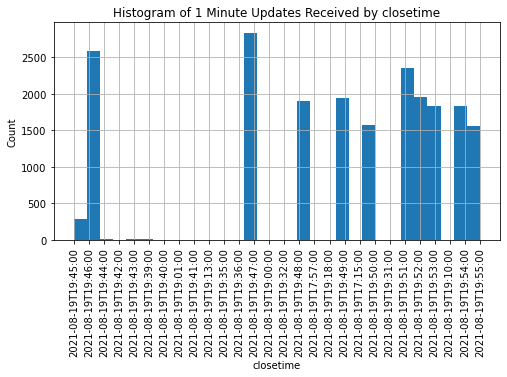

In [19]:
plt.figure(figsize=(8,4))
n, bins, patches = plt.hist(min_int, 'auto')


plt.xlabel('closetime')
plt.ylabel('Count')
plt.title('Histogram of 1 Minute Period Received by closetime')
plt.xticks(rotation=90)
plt.grid(True)

plt.show()

### CONCLUSION
Data that has been retrieved in preliminary work will need to be expanded upon. As this is a streaming pipeline, sufficient overhead for storaage will need to be established. 

Additionally, it will need to be determined if the ohlc data or the raw trade activities will be the stream type of data needed. Work will need to be done to parse out the protocol buffer type that is streamed in. For recall purposes, it will be beneficial to organize the returned values such that the keys are more meaningful.